In [1]:
cd C:\Users\desh669\OneDrive - PNNL\Documents\Python Scripts\Mobility Rahul\Anomaly Detection

C:\Users\desh669\OneDrive - PNNL\Documents\Python Scripts\Mobility Rahul\Anomaly Detection


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import datetime, timedelta
import timeit
from timeit import default_timer as timer
import glob
import os
from functools import reduce
import missingpy
from missingpy import KNNImputer
from fancyimpute import KNN
from fancyimpute import IterativeImputer
import scipy
from scipy.spatial.distance import pdist
from sklearn import preprocessing

Using TensorFlow backend.


In [3]:
### This Data set contains information about all the sensors which were reported as 'Good' on 25th Sept (Adopted from Caltrans website)
health_data = pd.read_csv('Good_Data_25thSept.csv',sep = ',')
#health_data.head()

## For initial analysis we will only select highway - US101S
health_data_US101S = health_data.loc[health_data['Fwy'] == 'US101-S']

### We do not need information about every lane of that sensor, just keeping the last observation to get the count of 
### number of lanes for that particular loop
health_data_US101S = health_data_US101S.drop_duplicates(subset=['VDS'],keep = 'last')
health_data_US101S = health_data_US101S.reset_index(drop = True)
#print(health_data_US101S.head())
#print(health_data_US101S.shape)

In [172]:
### Now as we know the list of sensors which reported good data on 25th Sept, we will try to get the data reported
### by them from the raw data we are collecting
li_processed_files = []
def pre_processing(day):
    path = r'C:\Users\desh669\OneDrive - PNNL\Documents\Python Scripts\Mobility Rahul\\' + day + '\\'
    all_files = glob.glob(path + "/*.txt")
    colnames = ["VDS_ID","Lane Count","Loop Count","Loop_1_FLOW","Loop_1_Occupancy","Loop_1_status","Loop_2_FLOW",
                "Loop_2_Occupancy", "Loop_2_status","Loop_3_FLOW","Loop_3_Occupancy","Loop_3_status","Loop_4_FLOW",
                "Loop_4_Occupancy","Loop_4_status","Loop_5_FLOW","Loop_5_Occupancy","Loop_5_status","Loop_6_FLOW",
                "Loop_6_Occupancy","Loop_6_status","Loop_7_FLOW","Loop_7_Occupancy","Loop_7_status","Loop_8_FLOW",
                "Loop_8_Occupancy","Loop_8_status","Loop_9_FLOW","Loop_9_Occuapncy","Loop_9_status","Loop_10_FLOW",
                "Loop_10_Occupancy","Loop_10_status"]
    for filename in all_files:
        if  int(filename[-10:-8]) >= 5 and int(filename[-10:-8]) <=21:        
            df = pd.read_csv(filename,index_col = None, delimiter = ",",names = colnames ,skiprows = 1)
            df= df.drop(['Lane Count','Loop Count','Loop_1_status','Loop_8_status','Loop_2_status','Loop_3_status',
                         'Loop_4_status','Loop_5_status','Loop_6_status','Loop_7_status','Loop_8_status','Loop_9_status',
                         'Loop_10_status'],axis = 1)
            #df = df.loc[df['VDS_ID'].isin(health_data_US101S.VDS.values)] 
            df['time'] = datetime.strptime(str(int(filename[-18:-4])),'%Y%m%d%H%M%S')
            
            li_processed_files.append(df)
        else:
            continue 
    return li_processed_files

### This function is slow because of df = df.loc[df['VDS_ID'].isin(health_data_US101S.VDS.values)] 

In [173]:
start = timer()
pre_processing('20190930')
end = timer()
print(f'Time required to process files : {end-start} seconds')

Time required to process files : 45.630331958062015 seconds


In [174]:
## Saving the list of dataframes in another list as well just for safety
new_list = []
new_list = li_processed_files.copy()
print(len(new_list))

li_processed_files = [dataframe.reset_index(drop = True) for dataframe in li_processed_files]

print(len(li_processed_files))
print(li_processed_files[0].shape)

li_processed_files = [df.loc[df['VDS_ID'].isin(health_data_US101S.VDS.values)] for df in li_processed_files]
print(li_processed_files[0].shape)

2040
2040
(2123, 22)
(81, 22)


In [175]:
### getting data in the required format : all indexes are loop IDs and column names are timestamps throughout the day
start = timer()
## Now in order to find the euclidean distances between sensors, first we need to arrange their data in vector format.
temp_df = pd.concat(li_processed_files)


tg = temp_df.groupby('VDS_ID')

## dropping unnecessary columns

li_groups = []
for name, group in tg:
    group = group[[each for each in group.columns if 'Occupancy' not in each]]
    li_groups.append(group)
    
## Rearranging data to get all the sensor Id as index and all the timestamps as column names

li_complete_groups = []
for dataframe in li_groups:
    dataframe = dataframe[[column for column in dataframe.columns if 'Occuapncy' not in column]]
    dataframe = dataframe.dropna(axis = 1,how = 'all')
    dataframe = dataframe.reset_index(drop = True)
    cols = dataframe.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    dataframe = dataframe[cols]
    dataframe = dataframe.T
    new_header = dataframe.iloc[0]
    dataframe = dataframe[1:]
    dataframe.columns = new_header   
    dataframe.index = dataframe.index + '_' + str(dataframe.iloc[0].values[0])
    dataframe = dataframe[1:]
    li_complete_groups.append(dataframe)
#print(len(li_complete_groups))

### since we have few sensors in every list, get them in a dataframe
data_MICE = pd.concat(li_complete_groups)
#print(data_KNN.shape)



## Let's see how the data looks like
data_MICE.head()

### need to impute the misssing values with zero to be able to calculate the distances 
### (otherwise getting null values in numpy array of distances) - There were not too many missing values since these sensors
### were in good health on 25th Sept. (less than 1% missing values)
data_MICE = data_MICE.fillna(0)

## check if there are still missing values
#len(data_KNN.index) - data_KNN.count()

## Change the data type to be able to calculate the distances
for col in data_MICE.columns:
    data_MICE[col] = data_MICE[col].astype(float)

end = timer()

print(end-start)

data_MICE.head()

27.204619245952927


time                2019-09-30 05:00:00  2019-09-30 05:00:30  \
Loop_1_FLOW_716328                  3.0                 16.0   
Loop_2_FLOW_716328                  9.0                 16.0   
Loop_3_FLOW_716328                  7.0                 11.0   
Loop_4_FLOW_716328                  7.0                  8.0   
Loop_1_FLOW_716331                  9.0                 15.0   

time                2019-09-30 05:01:00  2019-09-30 05:01:30  \
Loop_1_FLOW_716328                  2.0                  5.0   
Loop_2_FLOW_716328                  9.0                 10.0   
Loop_3_FLOW_716328                 15.0                  6.0   
Loop_4_FLOW_716328                 10.0                  8.0   
Loop_1_FLOW_716331                  4.0                  5.0   

time                2019-09-30 05:02:00  2019-09-30 05:02:30  \
Loop_1_FLOW_716328                  5.0                  7.0   
Loop_2_FLOW_716328                 10.0                  6.0   
Loop_3_FLOW_716328                  7.0                 10.0   
Loop_4_FLOW_716328                 10.0                 16.0   
Loop_1_FLOW_716331                  7.0                  8.0   

time                2019-09-30 05:03:00  2019-09-30 05:03:30  \
Loop_1_FLOW_716328                  8.0                  9.0   
Loop_2_FLOW_716328                 10.0                  8.0   
Loop_3_FLOW_716328                  7.0                  3.0   
Loop_4_FLOW_716328                 11.0                 10.0   
Loop_1_FLOW_716331                  7.0                  7.0   

time                2019-09-30 05:04:00  2019-09-30 05:04:30  ...  \
Loop_1_FLOW_716328                  6.0                  7.0  ...   
Loop_2_FLOW_716328                  8.0                  7.0  ...   
Loop_3_FLOW_716328                  9.0                 11.0  ...   
Loop_4_FLOW_716328                 15.0                  9.0  ...   
Loop_1_FLOW_716331                  8.0                 11.0  ...   

time                2019-09-30 21:55:00  2019-09-30 21:55:30  \
Loop_1_FLOW_716328                  4.0                 11.0   
Loop_2_FLOW_716328                 11.0                 15.0   
Loop_3_FLOW_716328                 11.0                 10.0   
Loop_4_FLOW_716328                 16.0                 11.0   
Loop_1_FLOW_716331                  8.0                 13.0   

time                2019-09-30 21:56:00  2019-09-30 21:56:30  \
Loop_1_FLOW_716328                 11.0                  9.0   
Loop_2_FLOW_716328                 17.0                 16.0   
Loop_3_FLOW_716328                 11.0                 12.0   
Loop_4_FLOW_716328                  8.0                 13.0   
Loop_1_FLOW_716331                  8.0                 15.0   

time                2019-09-30 21:57:00  2019-09-30 21:57:30  \
Loop_1_FLOW_716328                 12.0                  9.0   
Loop_2_FLOW_716328                 11.0                 18.0   
Loop_3_FLOW_716328                 14.0                  9.0   
Loop_4_FLOW_716328                 15.0                 17.0   
Loop_1_FLOW_716331                  8.0                  6.0   

time                2019-09-30 21:58:00  2019-09-30 21:58:30  \
Loop_1_FLOW_716328                  6.0                 10.0   
Loop_2_FLOW_716328                 13.0                 14.0   
Loop_3_FLOW_716328                 13.0                 15.0   
Loop_4_FLOW_716328                 11.0                 15.0   
Loop_1_FLOW_716331                  7.0                  6.0   

time                2019-09-30 21:59:00  2019-09-30 21:59:30  
Loop_1_FLOW_716328                  7.0                  7.0  
Loop_2_FLOW_716328                 14.0                 13.0  
Loop_3_FLOW_716328                 14.0                 14.0  
Loop_4_FLOW_716328                 16.0                 13.0  
Loop_1_FLOW_716331                  6.0                  5.0  

[5 rows x 2040 columns]

In [176]:
data_MICE.T.to_csv('Data_MICE.csv')

In [211]:
cd C:\Users\desh669\OneDrive - PNNL\Documents\Rahul Important\Results of analysis

C:\Users\desh669\OneDrive - PNNL\Documents\Rahul Important\Results of analysis


In [212]:
# small_data = pd.read_csv('small_data.csv')
# small_data_mis = pd.read_csv('small_data_mis.csv')
complete_data  = pd.read_csv('complete_data.csv')

In [213]:
complete_data.index = data_MICE.T.index
complete_data.head()

Unnamed: 0  Loop_1_FLOW_716328  Loop_2_FLOW_716328  \
time                                                                      
2019-09-30 05:00:00           1           12.630173                   9   
2019-09-30 05:00:30           2           13.118521                  16   
2019-09-30 05:01:00           3           12.568108                   9   
2019-09-30 05:01:30           4           12.371777                  10   
2019-09-30 05:02:00           5           12.576070                  10   

                     Loop_3_FLOW_716328  Loop_1_FLOW_764853  \
time                                                          
2019-09-30 05:00:00                   7                   6   
2019-09-30 05:00:30                  11                  12   
2019-09-30 05:01:00                  15                   8   
2019-09-30 05:01:30                   6                   1   
2019-09-30 05:02:00                   7                   6   

                     Loop_1_FLOW_716331  Loop_2_FLOW_716331  
time                                                         
2019-09-30 05:00:00                   9                  11  
2019-09-30 05:00:30                  15                  15  
2019-09-30 05:01:00                   4                   9  
2019-09-30 05:01:30                   5                   8  
2019-09-30 05:02:00                   7                  10

In [214]:
df = pd.DataFrame({'Actual': data_MICE.T.Loop_1_FLOW_716328, 
                   'Using_BPCA' : complete_data.Loop_1_FLOW_716328})
df.index = data_MICE.T.index
df.head()

Actual  Using_BPCA
time                                   
2019-09-30 05:00:00     3.0   12.630173
2019-09-30 05:00:30    16.0   13.118521
2019-09-30 05:01:00     2.0   12.568108
2019-09-30 05:01:30     5.0   12.371777
2019-09-30 05:02:00     5.0   12.576070

In [216]:
np.sqrt(np.mean((df.Using_BPCA-df.Actual)**2))

2.9342650255778944

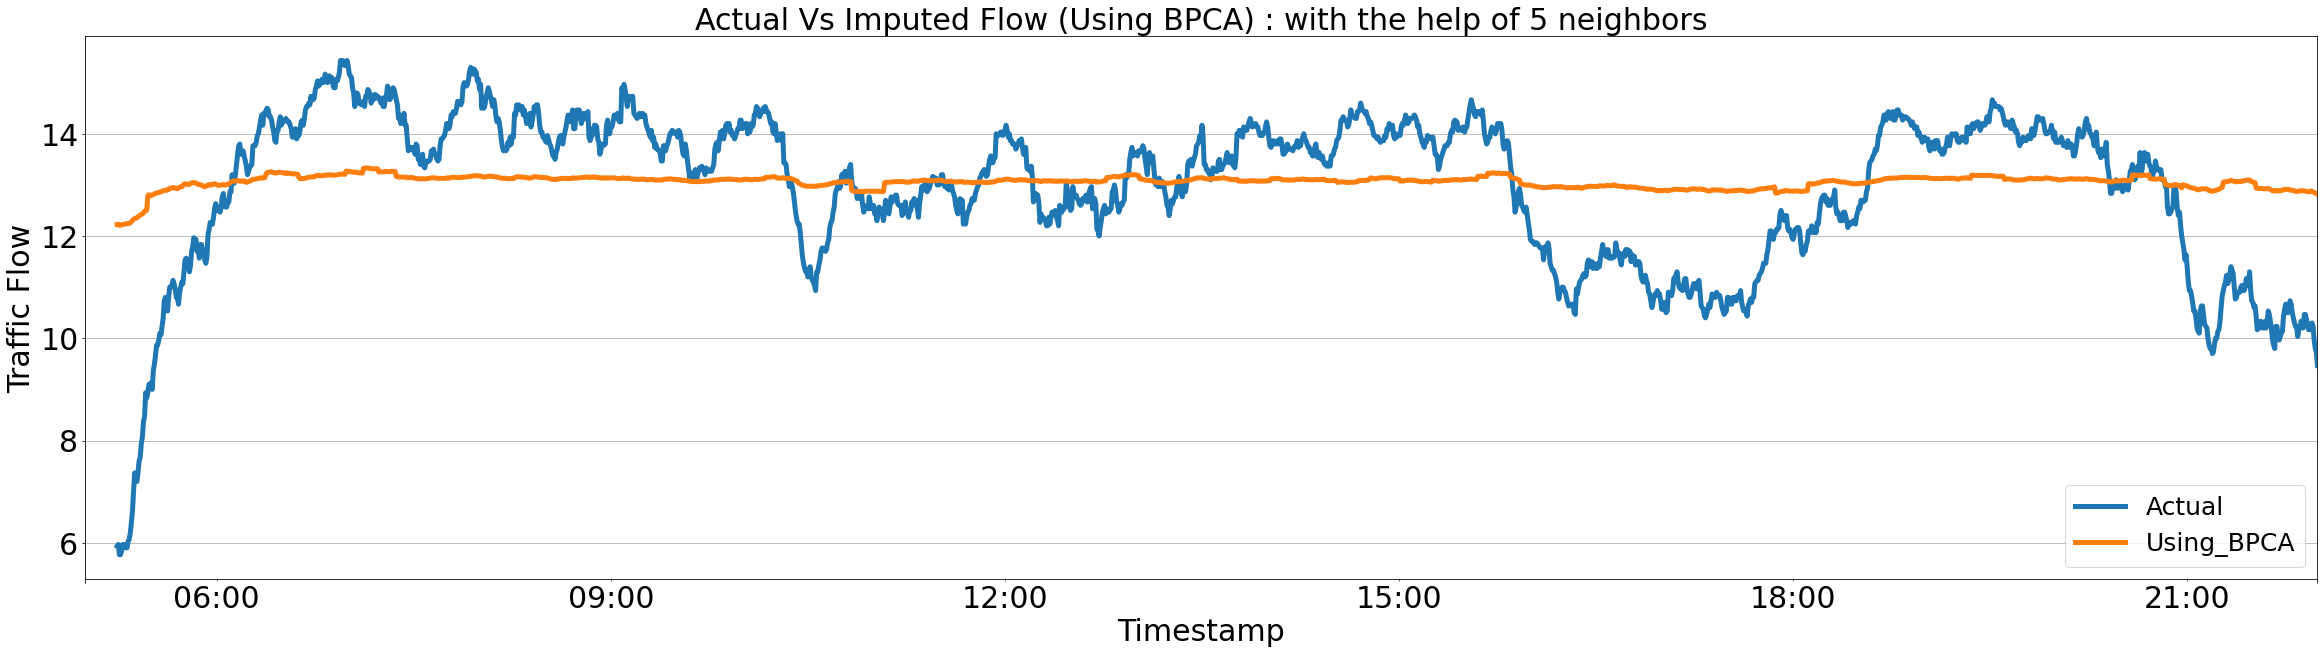

In [217]:
y = df.columns
for col in y:
    df[col].rolling(30).mean().plot(figsize=(40,10),linewidth=5,fontsize=30)
    plt.legend(y,fontsize = 25)
    plt.xlabel('Timestamp',fontsize = 30)
    plt.ylabel('Traffic Flow',fontsize = 30)
    plt.xticks(rotation = 10)
    plt.grid()
    plt.title('Actual Vs Imputed Flow (Using BPCA) : with the help of 5 neighbors',fontsize = 30)
    plt.savefig('BPCA_Final.png')

In [26]:
small_data = small_data.set_index('time',drop = True)
small_data_mis = small_data_mis.set_index('time',drop = True)
complete_data = complete_data.set_index('time',drop = True)

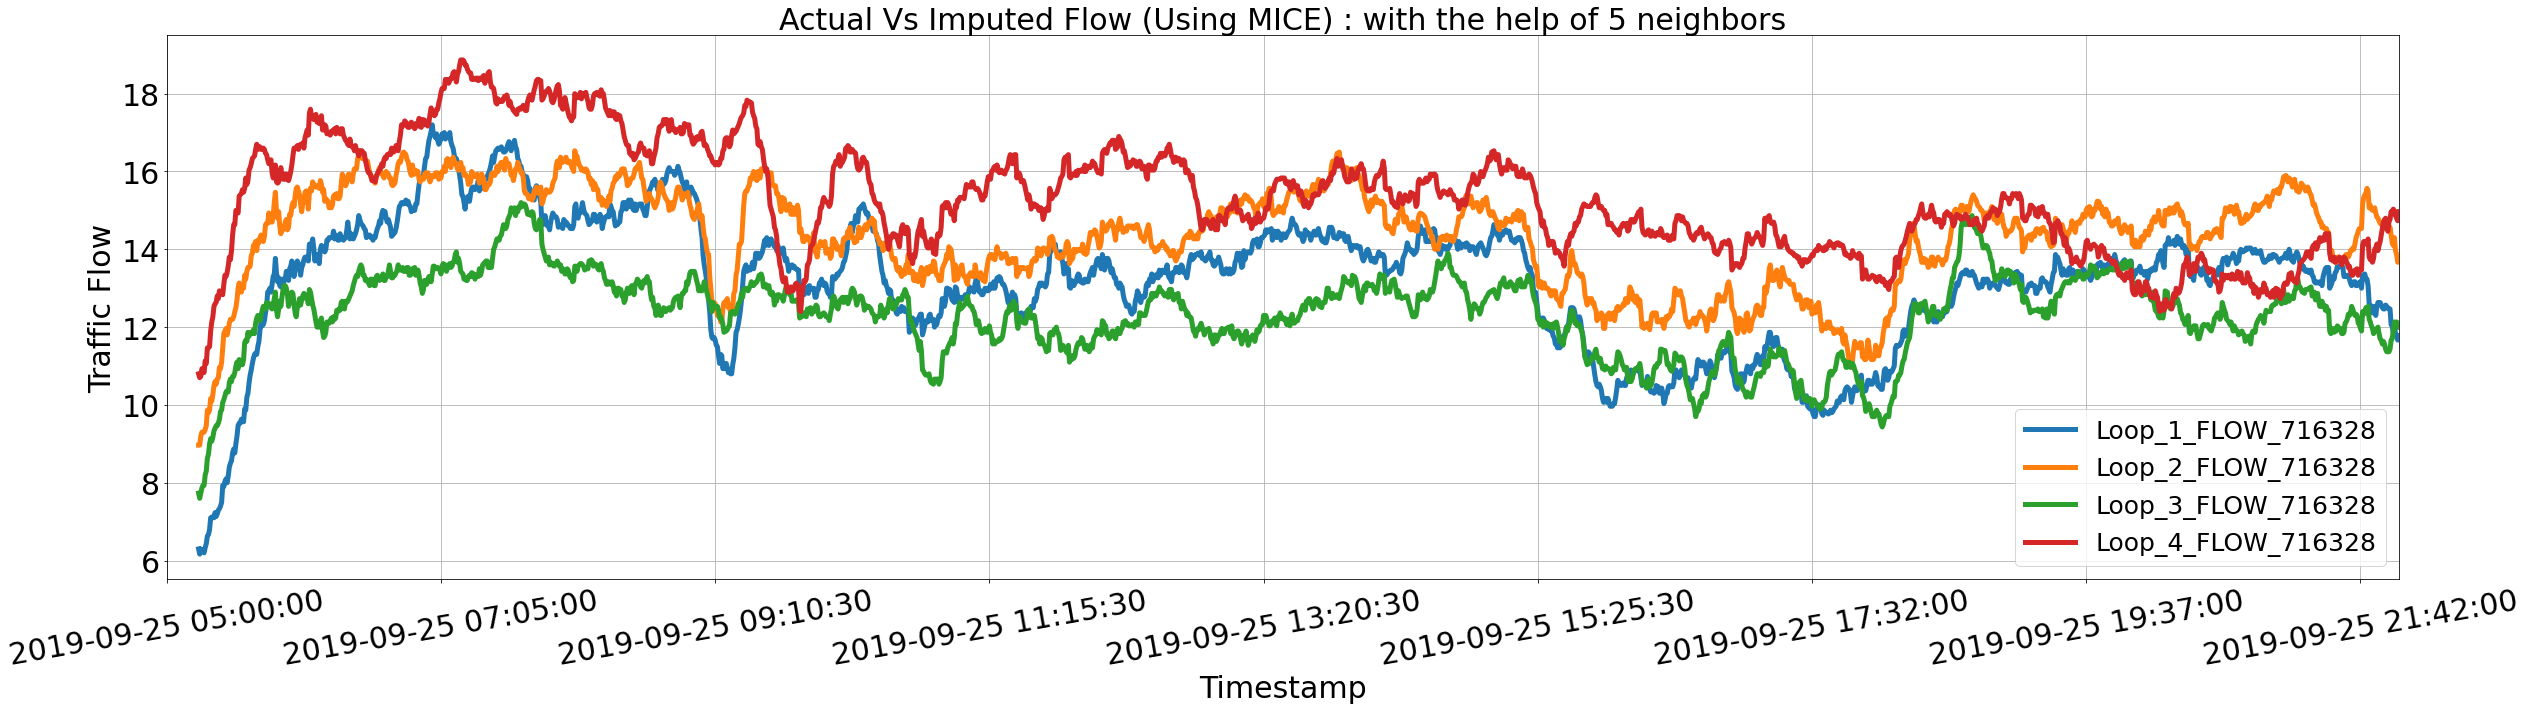

In [195]:
y = small_data.columns[1:5]
for col in y:
    small_data[col].rolling(30).mean().plot(figsize=(40,10),linewidth=5,fontsize=30)
    plt.legend(y,fontsize = 25)
    plt.xlabel('Timestamp',fontsize = 30)
    plt.ylabel('Traffic Flow',fontsize = 30)
    plt.xticks(rotation = 10)
    plt.grid()
    plt.title('Actual Vs Imputed Flow (Using MICE) : with the help of 5 neighbors',fontsize = 30)
    

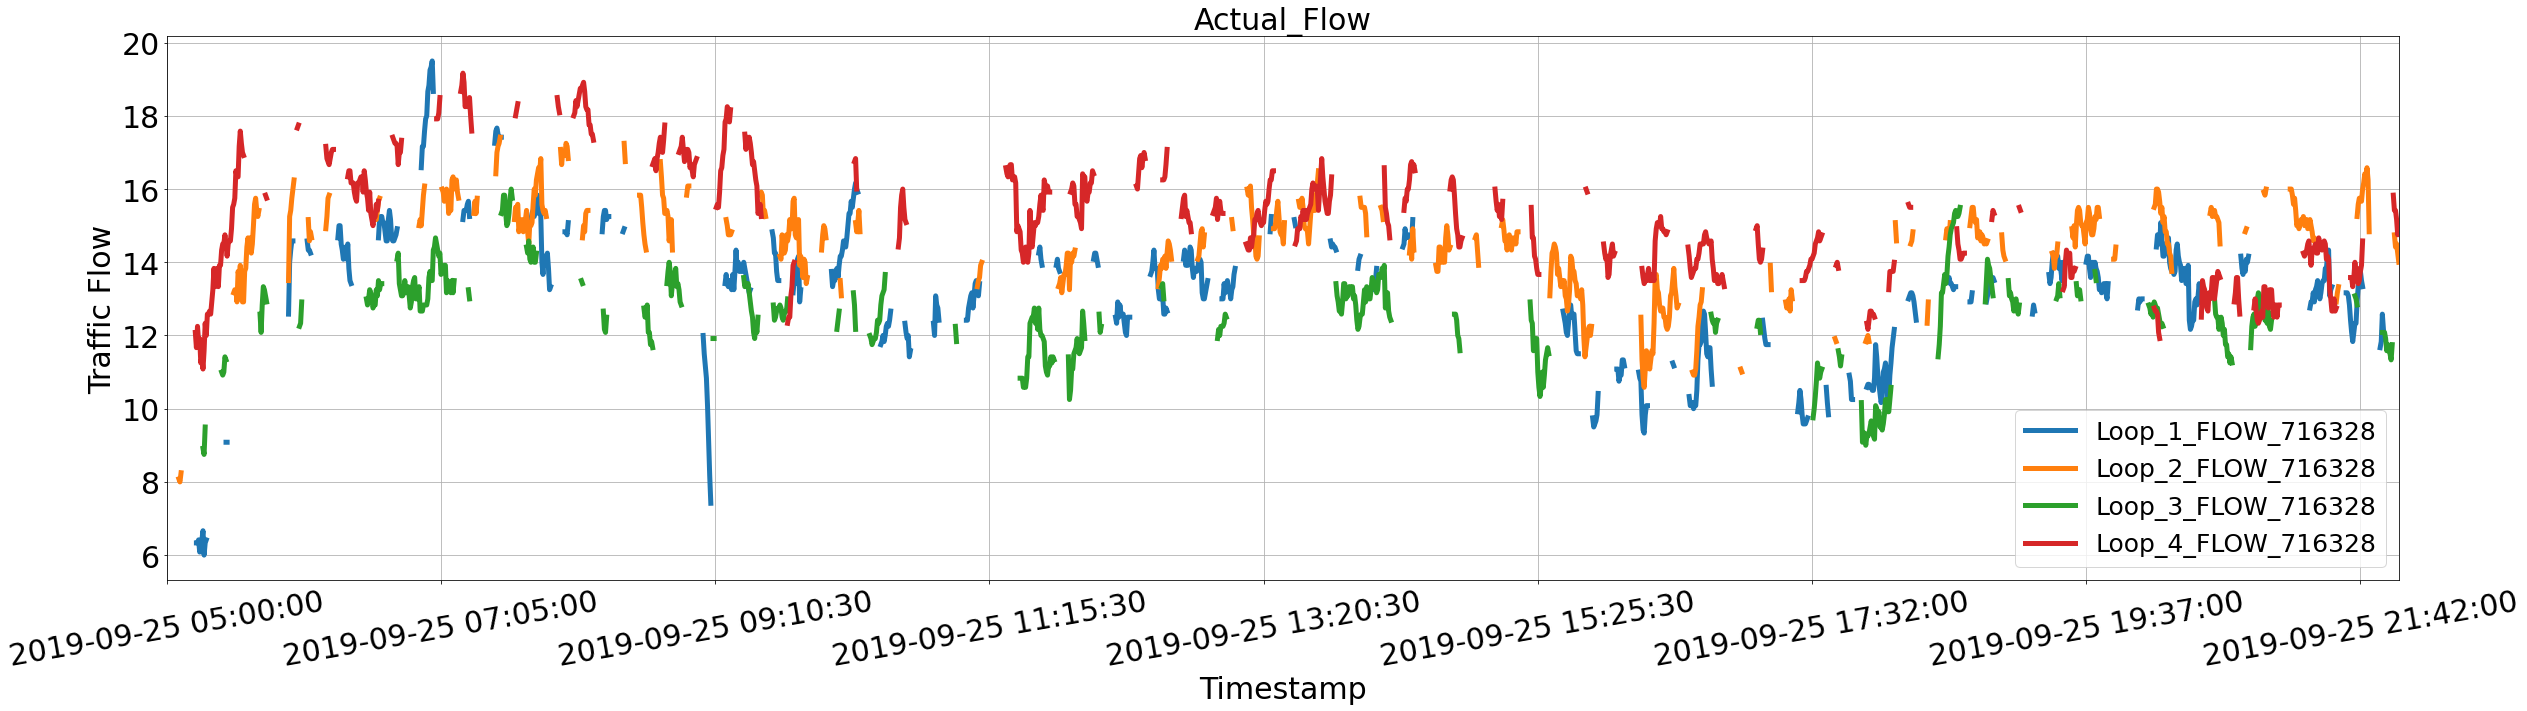

In [34]:
plt.close()
y = small_data_mis.columns[1:5]
for col in y:
    small_data_mis[col].rolling(12).mean().plot(figsize=(40,10),linewidth=5,fontsize=30)
    plt.legend(y,fontsize = 25)
    plt.xlabel('Timestamp',fontsize = 30)
    plt.ylabel('Traffic Flow',fontsize = 30)
    plt.xticks(rotation = 10)
    plt.grid()
    plt.title('Actual_Flow',fontsize = 30)

In [54]:
cd C:\Users\desh669\OneDrive - PNNL\Documents\Rahul Important\Results of analysis

C:\Users\desh669\OneDrive - PNNL\Documents\Rahul Important\Results of analysis


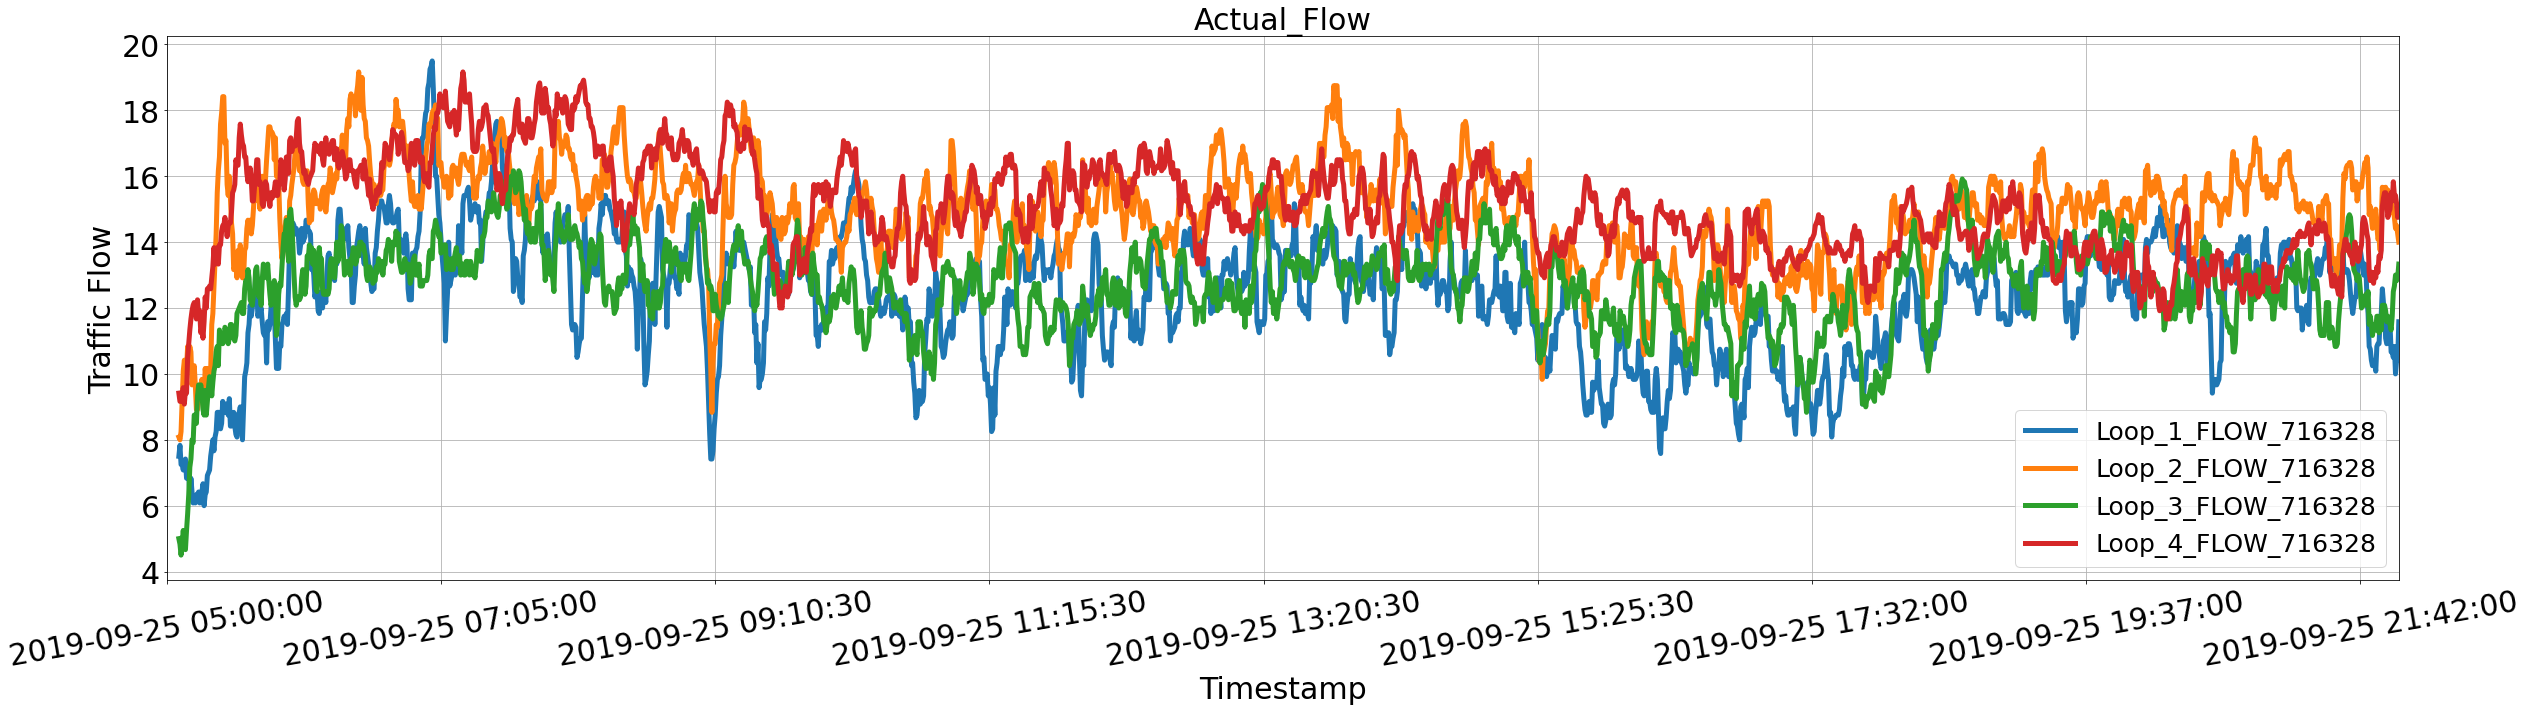

In [35]:
plt.close()
y = complete_data.columns[1:5]
for col in y:
    complete_data[col].rolling(12).mean().plot(figsize=(40,10),linewidth=5,fontsize=30)
    plt.legend(y,fontsize = 25)
    plt.xlabel('Timestamp',fontsize = 30)
    plt.ylabel('Traffic Flow',fontsize = 30)
    plt.xticks(rotation = 10)
    plt.grid()
    plt.title('Actual_Flow',fontsize = 30)

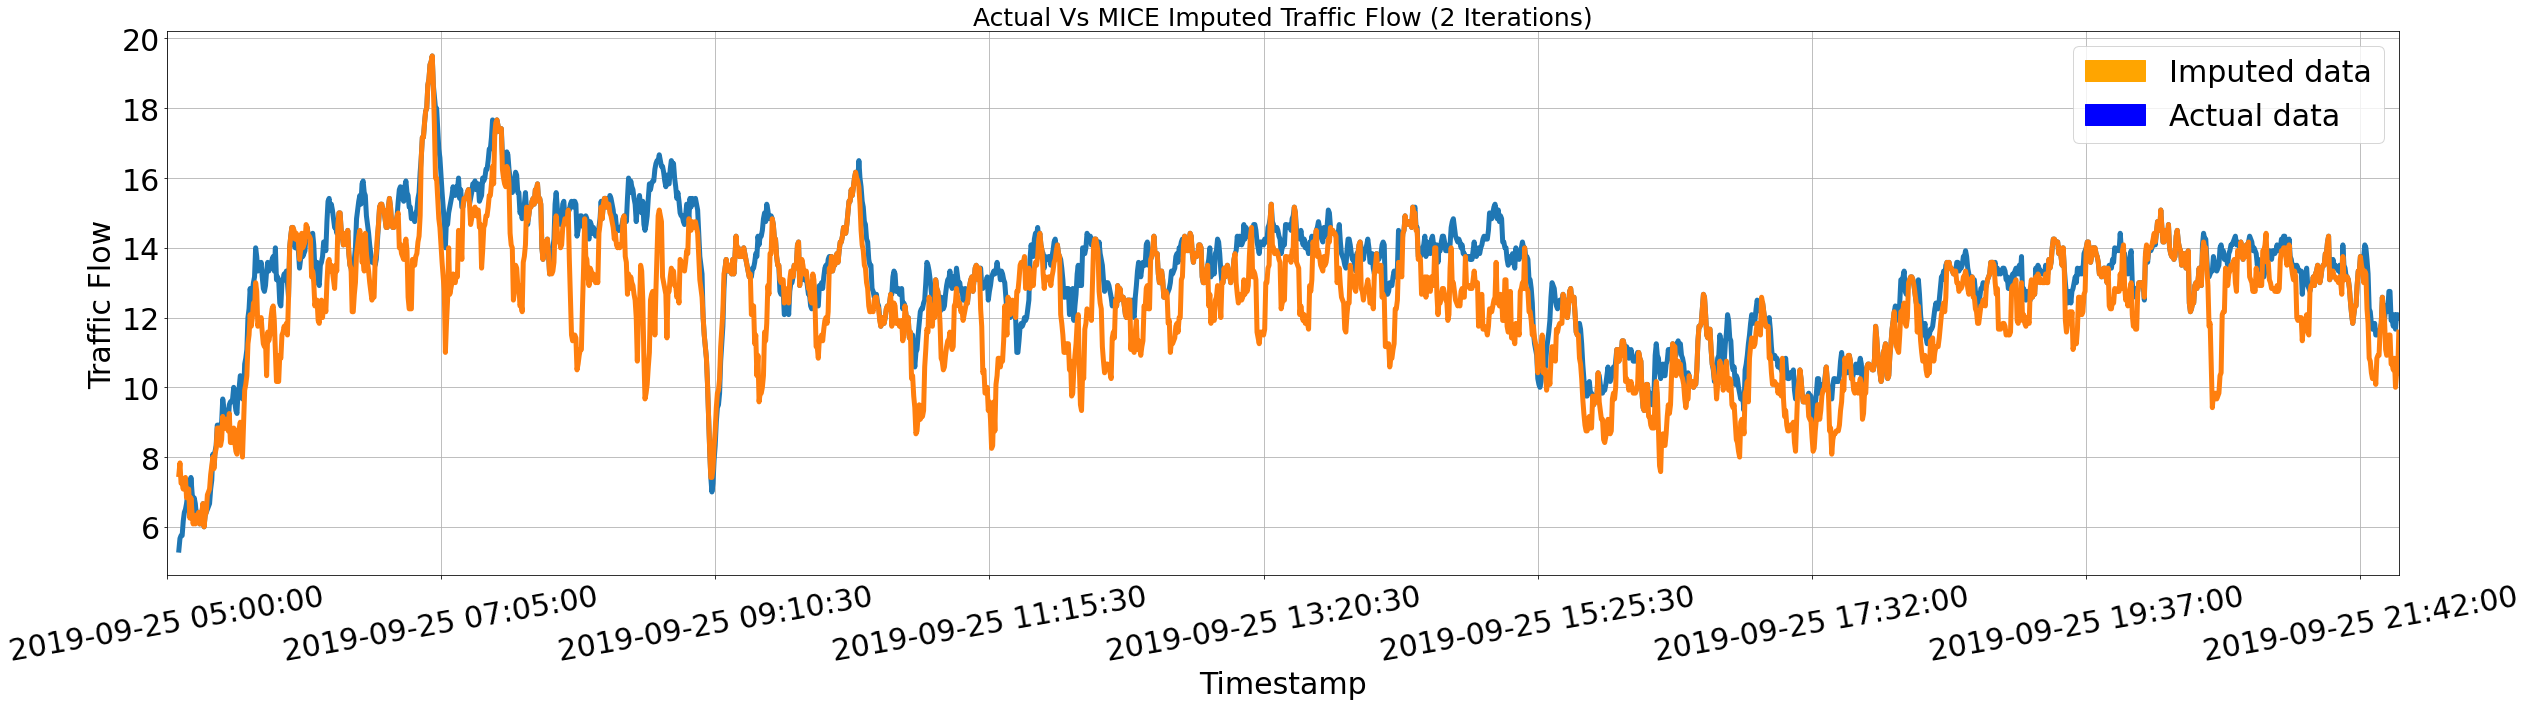

In [55]:
import matplotlib.patches as mpatches
small_data['Loop_1_FLOW_716328'].rolling(12).mean().plot(figsize=(40,10),linewidth=5,fontsize=30)
complete_data['Loop_1_FLOW_716328'].rolling(12).mean().plot(figsize=(40,10),linewidth=5,fontsize=30)
red_patch = mpatches.Patch(color='orange', label='Imputed data')
blue_patch = mpatches.Patch(color='blue', label='Actual data')
plt.legend(handles=[red_patch, blue_patch],fontsize = 30)
#plt.legend(fontsize=30)
plt.xticks(rotation = 10)
plt.xlabel('Timestamp',fontsize = 30)
plt.ylabel('Traffic Flow',fontsize = 30)
plt.title('Actual Vs MICE Imputed Traffic Flow (2 Iterations)',fontsize = 25)
plt.grid()
plt.savefig('MICE_1.png')

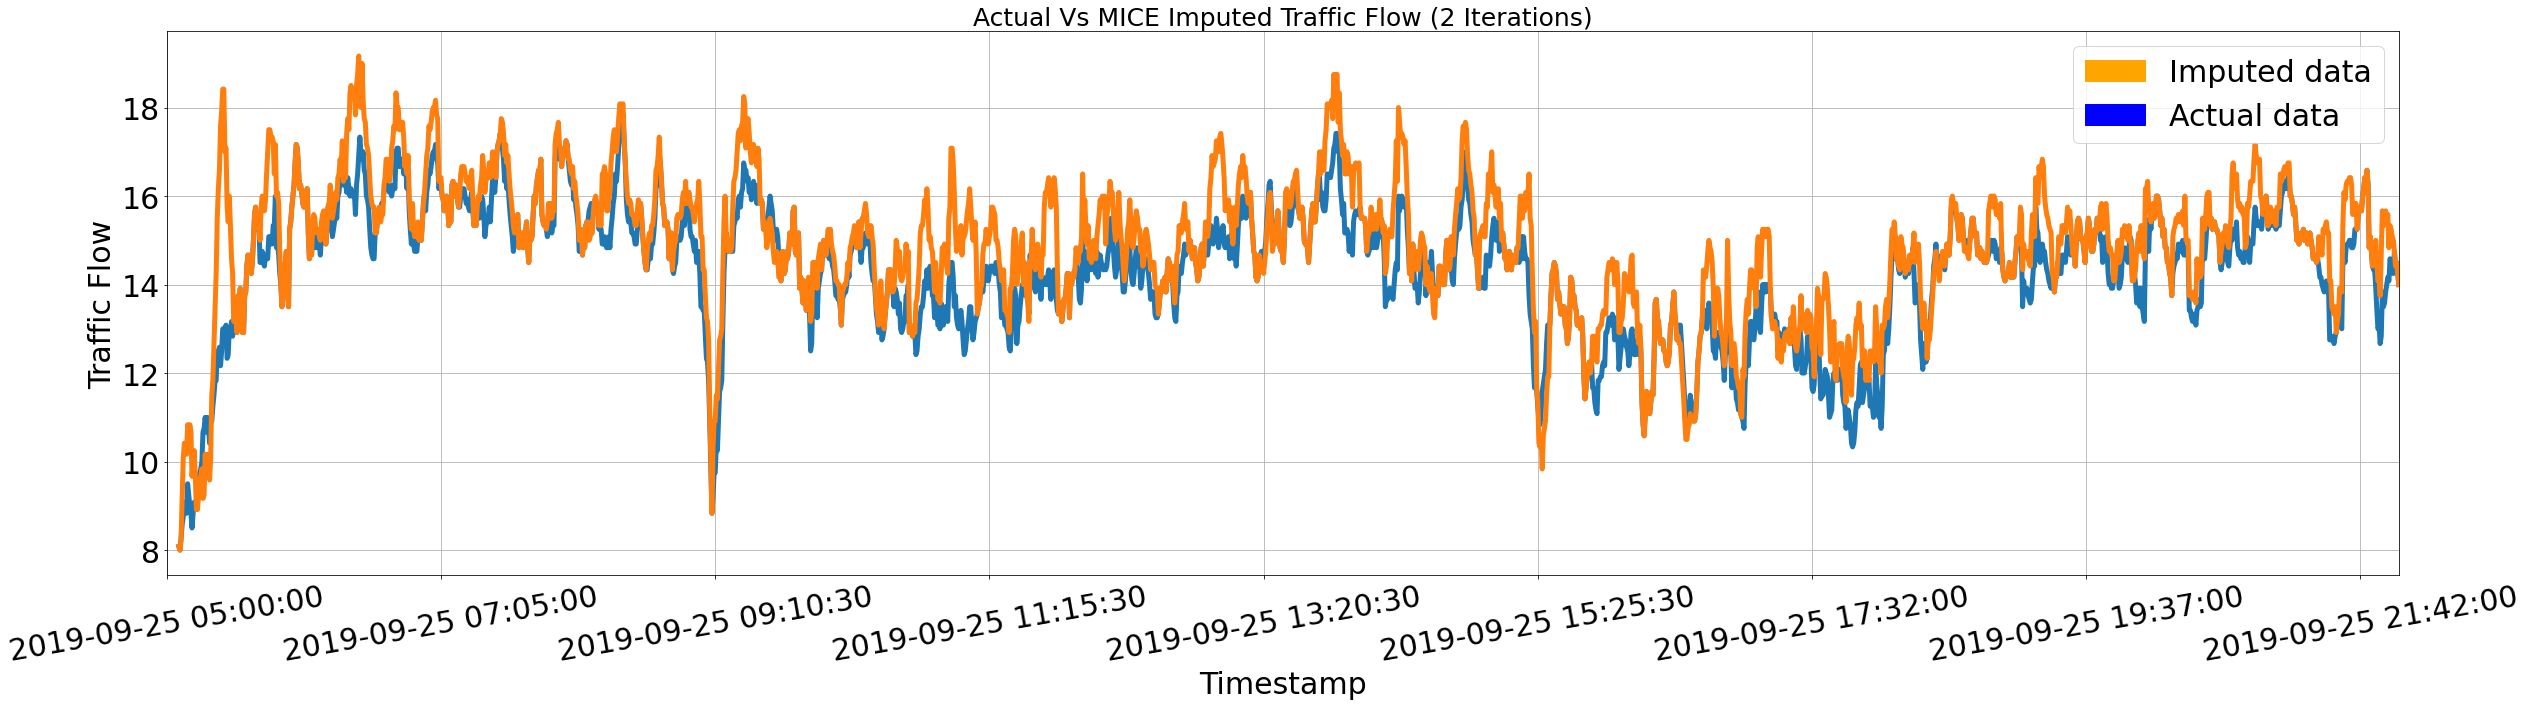

In [56]:
small_data['Loop_2_FLOW_716328'].rolling(12).mean().plot(figsize=(40,10),linewidth=5,fontsize=30)
complete_data['Loop_2_FLOW_716328'].rolling(12).mean().plot(figsize=(40,10),linewidth=5,fontsize=30)
red_patch = mpatches.Patch(color='orange', label='Imputed data')
blue_patch = mpatches.Patch(color='blue', label='Actual data')
plt.legend(handles=[red_patch, blue_patch],fontsize = 30)
#plt.legend(fontsize=30)
plt.xticks(rotation = 10)
plt.xlabel('Timestamp',fontsize = 30)
plt.ylabel('Traffic Flow',fontsize = 30)
plt.title('Actual Vs MICE Imputed Traffic Flow (2 Iterations)',fontsize = 25)
plt.grid()
plt.savefig('MICE_2.png')

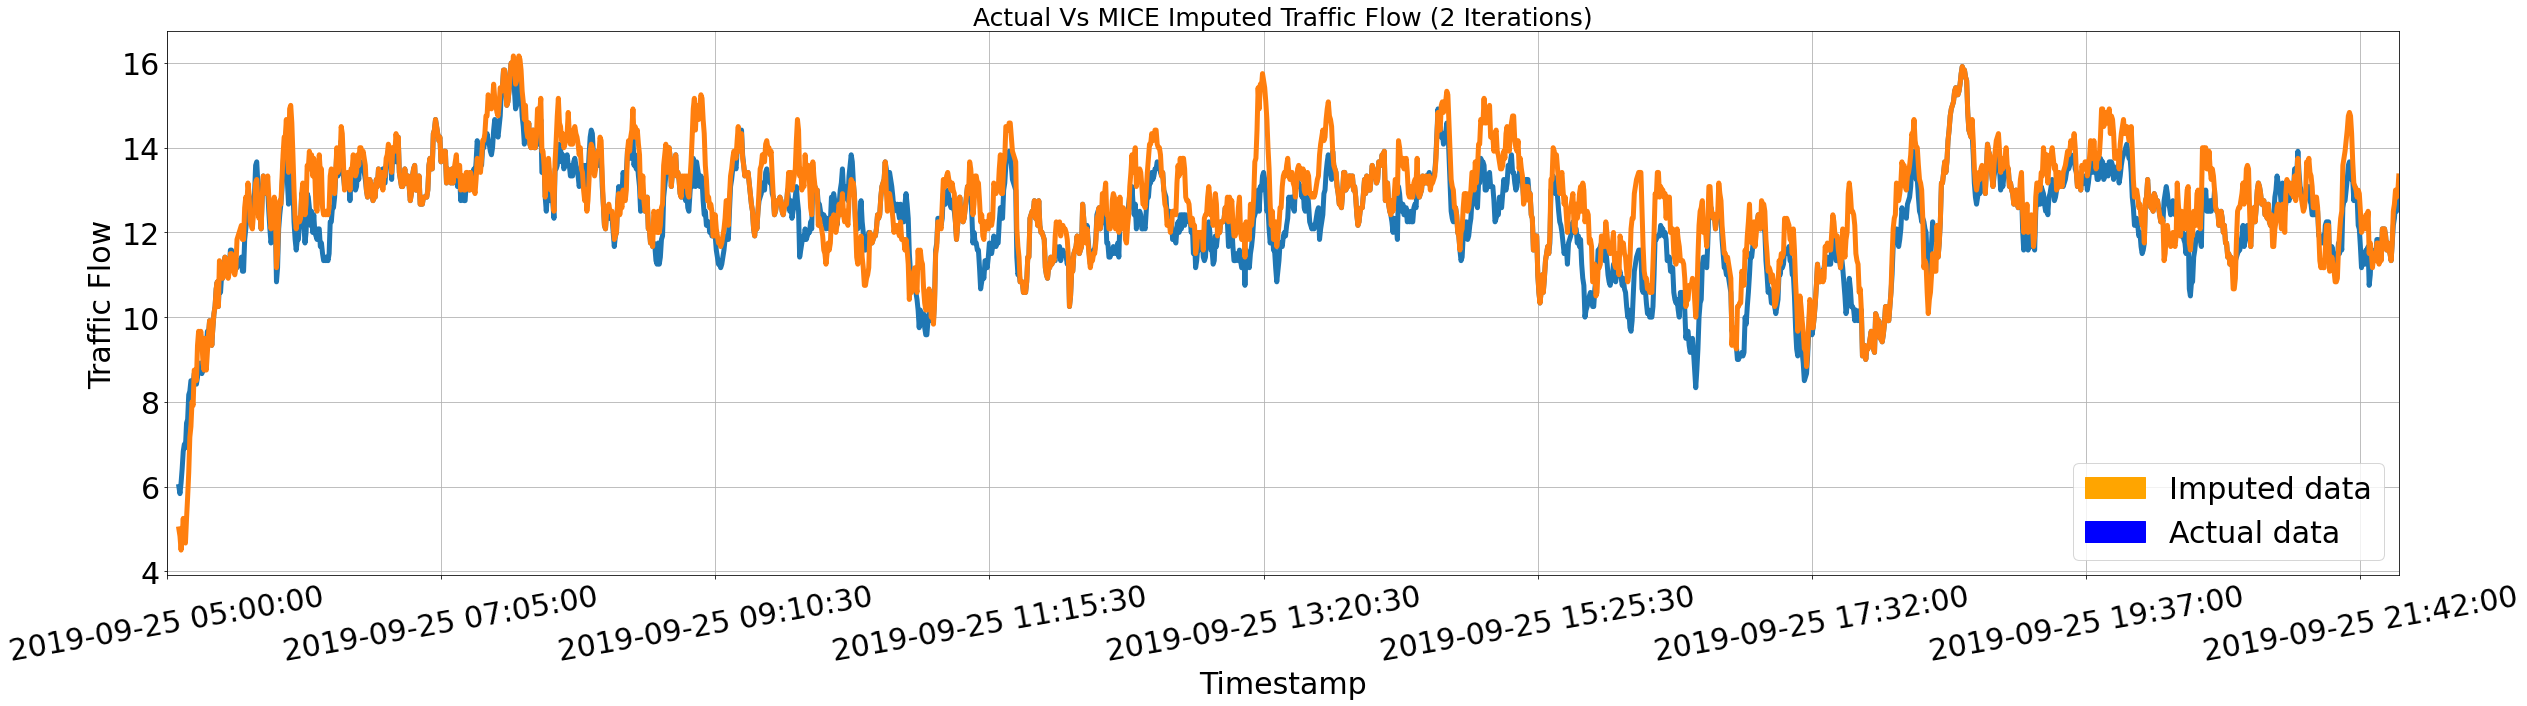

In [57]:
small_data['Loop_3_FLOW_716328'].rolling(12).mean().plot(figsize=(40,10),linewidth=5,fontsize=30)
complete_data['Loop_3_FLOW_716328'].rolling(12).mean().plot(figsize=(40,10),linewidth=5,fontsize=30)
red_patch = mpatches.Patch(color='orange', label='Imputed data')
blue_patch = mpatches.Patch(color='blue', label='Actual data')
plt.legend(handles=[red_patch, blue_patch],fontsize = 30)
#plt.legend(fontsize=30)
plt.xticks(rotation = 10)
plt.xlabel('Timestamp',fontsize = 30)
plt.ylabel('Traffic Flow',fontsize = 30)
plt.title('Actual Vs MICE Imputed Traffic Flow (2 Iterations)',fontsize = 25)
plt.grid()
plt.savefig('MICE_3.png')

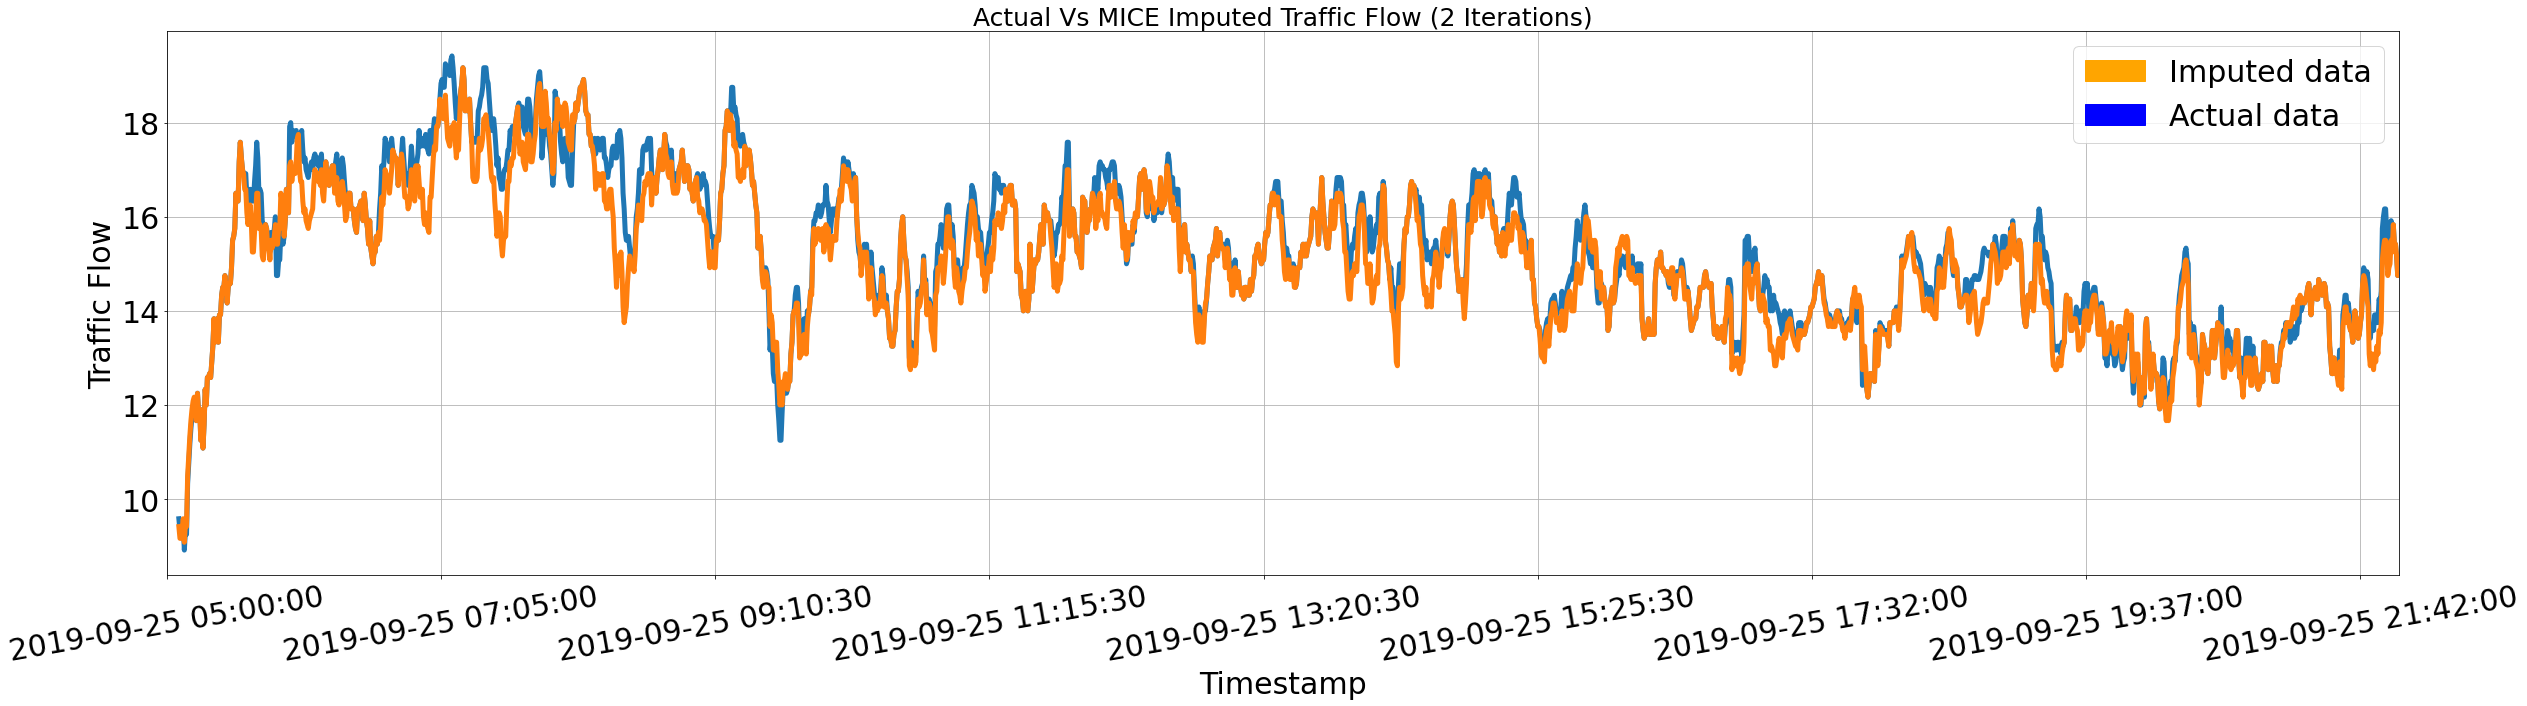

In [58]:
small_data['Loop_4_FLOW_716328'].rolling(12).mean().plot(figsize=(40,10),linewidth=5,fontsize=30)
complete_data['Loop_4_FLOW_716328'].rolling(12).mean().plot(figsize=(40,10),linewidth=5,fontsize=30)
red_patch = mpatches.Patch(color='orange', label='Imputed data')
blue_patch = mpatches.Patch(color='blue', label='Actual data')
plt.legend(handles=[red_patch, blue_patch],fontsize = 30)
#plt.legend(fontsize=30)
plt.xticks(rotation = 10)
plt.xlabel('Timestamp',fontsize = 30)
plt.ylabel('Traffic Flow',fontsize = 30)
plt.title('Actual Vs MICE Imputed Traffic Flow (2 Iterations)',fontsize = 25)
plt.grid()
plt.savefig('MICE_4.png')

In [73]:
small_data.head()
# len(small_data.index) - small_data.count()
# len(small_data_mis.index) - small_data_mis.count()

Unnamed: 0  Loop_1_FLOW_716328  Loop_2_FLOW_716328  \
time                                                                      
2019-09-25 05:00:00           1                   7                  10   
2019-09-25 05:00:30           2                   5                   5   
2019-09-25 05:01:00           3                   8                   8   
2019-09-25 05:01:30           4                   5                  10   
2019-09-25 05:02:00           5                   5                   8   

                     Loop_3_FLOW_716328  Loop_4_FLOW_716328  
time                                                         
2019-09-25 05:00:00                  12                  12  
2019-09-25 05:00:30                   4                   8  
2019-09-25 05:01:00                   6                  13  
2019-09-25 05:01:30                   5                  11  
2019-09-25 05:02:00                   7                  16

In [70]:
x = np.array(small_data.Loop_1_FLOW_716328).reshape(-1,1)
y = np.array(small_data.Loop_2_FLOW_716328).reshape(-1,1)
from sklearn.svm import SVR 
from sklearn.metrics import mean_squared_error 

model = SVR()
print(model)

model.fit(x,y)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)


C:\Users\desh669\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\desh669\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [71]:
y_pred = model.predict(x)

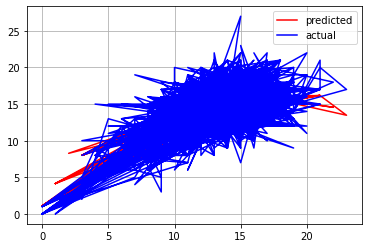

In [72]:
plt.plot(x, y_pred, lw=1.5, color="red", label="predicted")
plt.plot(x, y, lw=1.5, color="blue", label="actual")
plt.legend()
plt.grid()
plt.show()

In [136]:
small_data_mis = small_data_mis.replace(np.nan, " ")
small_data_mis = small_data_mis.drop(['Unnamed: 0'],axis = 1)
small_data_mis.head(11)

Loop_1_FLOW_716328 Loop_2_FLOW_716328 Loop_3_FLOW_716328  \
time                                                                           
2019-09-25 05:00:00                  7                 10                 12   
2019-09-25 05:00:30                                     5                  4   
2019-09-25 05:01:00                  8                  8                  6   
2019-09-25 05:01:30                  5                 10                  5   
2019-09-25 05:02:00                  5                  8                  7   
2019-09-25 05:02:30                  4                  9                  8   
2019-09-25 05:03:00                                     6                  3   
2019-09-25 05:03:30                  3                  3                      
2019-09-25 05:04:00                  6                 12                  6   
2019-09-25 05:04:30                                     5                  3   
2019-09-25 05:05:00                  4                  9                  6   

                    Loop_4_FLOW_716328  
time                                    
2019-09-25 05:00:00                 12  
2019-09-25 05:00:30                  8  
2019-09-25 05:01:00                     
2019-09-25 05:01:30                 11  
2019-09-25 05:02:00                 16  
2019-09-25 05:02:30                 10  
2019-09-25 05:03:00                  9  
2019-09-25 05:03:30                  4  
2019-09-25 05:04:00                     
2019-09-25 05:04:30                  9  
2019-09-25 05:05:00                  4

In [139]:
def extract_rows(data):
    rows,columns = len(data), len(data[0])
    complete_rows, incomplete_rows = [],[]
    for i in range(rows):
        for j in range(columns):
            if data[i][j] == " ":
                incomplete_rows.append(i)
                break
            else:
                complete_rows.append(i)
    return np.array(complete_rows),np.array(incomplete_rows)

In [141]:
def pre_processing(day):
    path = r'C:\Users\desh669\OneDrive - PNNL\Documents\Python Scripts\Mobility Rahul\\' + day + '\\'
    all_files = glob.glob(path + "/*.txt")
    colnames = ["VDS_ID","Lane Count","Loop Count","Loop_1_FLOW","Loop_1_Occupancy","Loop_1_status","Loop_2_FLOW",
                "Loop_2_Occupancy", "Loop_2_status","Loop_3_FLOW","Loop_3_Occupancy","Loop_3_status","Loop_4_FLOW",
                "Loop_4_Occupancy","Loop_4_status","Loop_5_FLOW","Loop_5_Occupancy","Loop_5_status","Loop_6_FLOW",
                "Loop_6_Occupancy","Loop_6_status","Loop_7_FLOW","Loop_7_Occupancy","Loop_7_status","Loop_8_FLOW",
                "Loop_8_Occupancy","Loop_8_status","Loop_9_FLOW","Loop_9_Occuapncy","Loop_9_status","Loop_10_FLOW",
                "Loop_10_Occupancy","Loop_10_status"]
    for filename in all_files:
        if  int(filename[-10:-8]) >= 5 and int(filename[-10:-8]) <=21:        
            df = pd.read_csv(filename,index_col = None, delimiter = ",",names = colnames ,skiprows = 1)
            df= df.drop(['Lane Count','Loop Count','Loop_1_status','Loop_8_status','Loop_2_status','Loop_3_status',
                         'Loop_4_status','Loop_5_status','Loop_6_status','Loop_7_status','Loop_8_status','Loop_9_status',
                         'Loop_10_status'],axis = 1)
            #df = df.loc[df['VDS_ID'].isin(health_data_US101S.VDS.values)] 
            df['time'] = datetime.strptime(str(int(filename[-18:-4])),'%Y%m%d%H%M%S')
            
            yield df
        else:
            continue

In [170]:
start = timer()
my_dataframe = pre_processing('20190925')
end = timer()
print(f'Time required to process files : {end-start} seconds')

Time required to process files : 7.325102342292666e-05 seconds


In [169]:
start = timer()
lis = [lis.append(i) for i in my_dataframe]
len(lis)

end = timer()

print(f'time required to process the files with the help of generators {end-start} seconds')

time required to process the files with the help of generators 53.657970859028865 seconds


In [ ]:
### getting data in the required format : all indexes are loop IDs and column names are timestamps throughout the day
start = timer()
## Now in order to find the euclidean distances between sensors, first we need to arrange their data in vector format.
temp_df = pd.concat(list(my_dataframes))


tg = temp_df.groupby('VDS_ID')

## dropping unnecessary columns

# li_groups = []
for name, group in tg:
    group = group[[each for each in group.columns if 'Occupancy' not in each]]
    yield group
    
## Rearranging data to get all the sensor Id as index and all the timestamps as column names

#li_complete_groups = []
for dataframe in list(group):
    dataframe = dataframe[[column for column in dataframe.columns if 'Occuapncy' not in column]]
    dataframe = dataframe.dropna(axis = 1,how = 'all')
    dataframe = dataframe.reset_index(drop = True)
    cols = dataframe.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    dataframe = dataframe[cols]
    dataframe = dataframe.T
    new_header = dataframe.iloc[0]
    dataframe = dataframe[1:]
    dataframe.columns = new_header   
    dataframe.index = dataframe.index + '_' + str(dataframe.iloc[0].values[0])
    dataframe = dataframe[1:]
    li_complete_groups.append(dataframe)
#print(len(li_complete_groups))

### since we have few sensors in every list, get them in a dataframe
data_MICE = pd.concat(li_complete_groups)
#print(data_KNN.shape)



## Let's see how the data looks like
data_MICE.head()

### need to impute the misssing values with zero to be able to calculate the distances 
### (otherwise getting null values in numpy array of distances) - There were not too many missing values since these sensors
### were in good health on 25th Sept. (less than 1% missing values)
data_MICE = data_MICE.fillna(0)

## check if there are still missing values
#len(data_KNN.index) - data_KNN.count()

## Change the data type to be able to calculate the distances
for col in data_MICE.columns:
    data_MICE[col] = data_MICE[col].astype(float)

end = timer()

print(end-start)

data_MICE.head()